In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IpoG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def load_doc(jsonFile):
    with open(jsonFile) as file:
        Json_data = json.loads(file.read())
    return Json_data

In [4]:
data = load_doc("F:\\Data Science Excler\\Project\\P50\\Final\\intents.json")

In [5]:
def frame_data(feat_1,feat_2,is_pattern):
    is_pattern = is_pattern
    df = pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w = pattern
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w = response
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
    return df

In [6]:
# users intents 
df1 = frame_data('questions','labels',True)
df1

,questions,labels
0,Hi there,start_conversation
1,Is anyone there?,start_conversation
2,Hey,start_conversation
3,Hola,start_conversation
4,Hello,start_conversation
...,...,...
84,What is Pruning in Decision Tree?,Decision_tree
85,What are the advantage of Pruning?,Decision_tree
86,What is the difference between Entropy and Inf...,Decision_tree
87,Explain the expression of Gain of any column?,Decision_tree


In [7]:
df1.labels.value_counts(sort=False)

normalization          8
thanks                 5
SVM                   10
what_are_you           4
probability            2
Decision_tree          9
function               7
distribution           2
start_conversation     7
Z_transformation       3
bot_scope              5
options                8
Clustering             8
KNN                    4
Naive_Bayes            2
end_conversation       5
Name: labels, dtype: int64

In [8]:
# Bot response
df2 = frame_data('response','labels',False)
df2.head()

,response,labels
0,"Hello, I'm sure you are interested in Data Sci...",start_conversation
1,Happy to have you here,start_conversation
2,Good to see you again,start_conversation
3,"Hi there, how can I help?",start_conversation
4,"Hi, I'm DS Chatbot",what_are_you


In [9]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [10]:
def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return 

In [11]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return 

In [12]:
create_vocab(tokenizer,df1,'questions')
remove_stop_words(tokenizer,df1,'questions')

In [13]:
print(vocab.most_common(20))

[('what', 45), ('is', 32), ('you', 24), ('in', 18), ('do', 17), ('the', 15), ('of', 15), ('are', 10), ('svm', 10), ('how', 8), ('by', 8), ('clustering', 8), ('to', 7), ('data', 7), ('mean', 7), ('decision', 6), ('tree', 6), ('can', 5), ('about', 5), ('science', 5)]


In [14]:
vocab_size = len(vocab)
vocab_size

170

In [15]:
df1

,questions,labels
0,hi there,start_conversation
1,is anyone there,start_conversation
2,hey,start_conversation
3,hola,start_conversation
4,hello,start_conversation
...,...,...
84,what is pruning in decision tree,Decision_tree
85,what are the advantage of pruning,Decision_tree
86,what is the difference between entropy and inf...,Decision_tree
87,explain the expression of gain of any column,Decision_tree


In [16]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['why is hierarchial clustering called agglomerative clustering',
 'what is decision tree',
 'why is knn called nonparametric algorithm',
 'what is bayes theorem',
 'what is svm',
 'what is the range of transformed variable',
 'what do you know about data science',
 'what do you mean by degree of freedom',
 'bye',
 'what do you mean by hypothesis testing',
 'what is the range of variable when normalization technique is employed',
 'how can you help me',
 'what is probability',
 'hi there',
 'thanks',
 'what is your name']

In [17]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[44, 80, 72, 78, 34, 52, 29, 63, 11, 65, 55, 21, 76, 0, 16, 7]

In [18]:
train_index = [i for i in df1.index if i not in test_index]

In [19]:
' '.join(list(vocab.keys()))

'hi there is anyone hey hola hello good day what your name are you who pls bye see later goodbye nice chatting to till next time thanks thank thats helpful awesome for helping me how can help do provide be support offered know about data science tell really lot exactly mean by guide through svm the tuning parameter of explain kernel in need convert categorical variable into numeric if yes regularization gamma margin package used function implement hinge loss why hierarchial clustering called agglomerative when say that resultant cluster which domain we employ example normalization required before applying linkage decide upon number interpret output range transformed roc ztransform any signal cannot contain pole true or false transformation technique employed dummy heteroscedasticity multicollinearity test understand use degree freedom go distribution hypothesis testing null curve work naive bayes so prior probability difference between covariance and correlation knn nonparametric algor

In [20]:
def encoder(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size = len(t.word_index) + 1
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    encoded = t.texts_to_sequences(entries)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded, vocab_size

In [21]:
X,vocab_size = encoder(df1,'questions')

In [22]:
df_encoded = pd.DataFrame(X)

In [23]:
df_encoded['labels'] = df1.labels
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,labels
0,45,30,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
1,2,66,30,0,0,0,0,0,0,0,0,0,0,0,start_conversation
2,67,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
3,68,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation
4,69,0,0,0,0,0,0,0,0,0,0,0,0,0,start_conversation


In [24]:
for i in range(0,2):
    dt = [0]*14
    dt.append('confused')
    dt = [dt]
    pd.DataFrame(dt).rename(columns = {14:'labels'})
    df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {14:'labels'}),ignore_index=True)

In [25]:
df_encoded.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,labels
86,1,2,6,42,43,167,28,168,65,0,0,0,0,0,Decision_tree
87,21,6,169,7,65,7,60,170,0,0,0,0,0,0,Decision_tree
88,1,2,6,51,57,13,53,16,17,4,0,0,0,0,Decision_tree
89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,confused
90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,confused


In [26]:
train_index.append(89)

In [27]:
test_index.append(90)

In [28]:
# df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {16:'labels'}),ignore_index=True)

In [29]:
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

In [30]:
labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16,  9,  9,  9,  9,  9, 15,
       15, 15, 15, 15, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,  6,  6,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,
        0,  5,  5,  5, 11, 11, 11, 11, 11, 11, 11, 11,  8,  8, 10, 10, 10,
       10, 10, 10, 10,  2,  2,  2,  2, 13, 13,  3,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  7,  7])

In [31]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'start_conversation': 14,
 'what_are_you': 16,
 'end_conversation': 9,
 'thanks': 15,
 'options': 12,
 'bot_scope': 6,
 'SVM': 4,
 'Clustering': 0,
 'Z_transformation': 5,
 'normalization': 11,
 'distribution': 8,
 'function': 10,
 'KNN': 2,
 'probability': 13,
 'Naive_Bayes': 3,
 'Decision_tree': 1,
 'confused': 7}

In [32]:
df2.head()

,response,labels
0,"Hello, I'm sure you are interested in Data Sci...",start_conversation
1,Happy to have you here,start_conversation
2,Good to see you again,start_conversation
3,"Hi there, how can I help?",start_conversation
4,"Hi, I'm DS Chatbot",what_are_you


In [33]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.head()

,response,labels
0,"Hello, I'm sure you are interested in Data Sci...",14
1,Happy to have you here,14
2,Good to see you again,14
3,"Hi there, how can I help?",14
4,"Hi, I'm DS Chatbot",16


In [34]:
df2.to_csv('response.csv',index=False)

In [35]:
# df2.groupby('labels').get_group(11)

In [36]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

In [37]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels


In [38]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [39]:
y_train[0].shape,y_test[0].shape

((17,), (17,))

In [40]:
X_train.shape

(74, 14)

In [41]:
max_length = X_train.shape[1]
# output = len(df3.labels.unique())
output = 17

In [42]:
# def define_model(vocab_size, max_length):
#     model = Sequential()
#     model.add(Embedding(vocab_size,300, input_length=max_length))
#     model.add(Conv1D(filters=64, kernel_size=6, activation='relu'))
#     model.add(MaxPooling1D(pool_size=4))
#     model.add(Flatten())
# #     model.add(Dense(32, activation='relu'))
#     model.add(Dense(16, activation='softmax'))
    
#     # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # summarize defined model
#     model.summary()
# #     plot_model(model, to_file='model.png', show_shapes=True)
#     return model

In [43]:
max_length

14

In [44]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)
callbacks = [early_stopping,checkpoint,reduce_lr]
    
    

In [45]:

def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,300, input_length=max_length))
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Flatten())
#     model.add(Dense(32, activation='relu'))
    model.add(Dense(17, activation='softmax'))
    
    
    # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss = 'categorical_crossentropy',
              # optimizer = Adam(lr=0.001),
              optimizer = 'adam',
              metrics = ['accuracy'])
    
    # summarize defined model
    model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [46]:
# define model
model = define_model(vocab_size, max_length)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 300)           51300     
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 64)            76864     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 17)                1105      
Total params: 129,269
Trainable params: 129,269
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(X_train, y_train, epochs=500, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/500
3/3 [==============================] - 4s 750ms/step - loss: 2.8299 - accuracy: 0.0676 - val_loss: 2.8111 - val_accuracy: 0.1176

Epoch 00001: val_loss improved from inf to 2.81111, saving model to model-v1.h5
Epoch 2/500
3/3 [==============================] - 0s 53ms/step - loss: 2.7238 - accuracy: 0.3514 - val_loss: 2.7958 - val_accuracy: 0.1765

Epoch 00002: val_loss improved from 2.81111 to 2.79581, saving model to model-v1.h5
Epoch 3/500
3/3 [==============================] - 0s 50ms/step - loss: 2.6455 - accuracy: 0.5270 - val_loss: 2.7822 - val_accuracy: 0.1176

Epoch 00003: val_loss improved from 2.79581 to 2.78221, saving model to model-v1.h5
Epoch 4/500
3/3 [==============================] - 0s 60ms/step - loss: 2.5705 - accuracy: 0.6081 - val_loss: 2.7638 - val_accuracy: 0.1176

Epoch 00004: val_loss improved from 2.78221 to 2.76384, saving model to model-v1.h5
Epoch 5/500
3/3 [==============================] - 0s 93ms/step - loss: 2.4957 - accuracy: 0.6622 - val

3/3 [==============================] - 0s 129ms/step - loss: 0.1610 - accuracy: 0.9865 - val_loss: 1.6108 - val_accuracy: 0.5294

Epoch 00037: val_loss improved from 1.64724 to 1.61082, saving model to model-v1.h5
Epoch 38/500
3/3 [==============================] - 0s 62ms/step - loss: 0.1455 - accuracy: 0.9865 - val_loss: 1.5812 - val_accuracy: 0.5294

Epoch 00038: val_loss improved from 1.61082 to 1.58122, saving model to model-v1.h5
Epoch 39/500
3/3 [==============================] - 0s 81ms/step - loss: 0.1334 - accuracy: 0.9865 - val_loss: 1.5545 - val_accuracy: 0.5294

Epoch 00039: val_loss improved from 1.58122 to 1.55445, saving model to model-v1.h5
Epoch 40/500
3/3 [==============================] - 0s 88ms/step - loss: 0.1218 - accuracy: 0.9865 - val_loss: 1.5337 - val_accuracy: 0.5294

Epoch 00040: val_loss improved from 1.55445 to 1.53369, saving model to model-v1.h5
Epoch 41/500
3/3 [==============================] - 0s 128ms/step - loss: 0.1118 - accuracy: 0.9865 - val_lo

3/3 [==============================] - 0s 56ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 1.3604 - val_accuracy: 0.6471

Epoch 00073: val_loss improved from 1.36343 to 1.36042, saving model to model-v1.h5
Epoch 74/500
3/3 [==============================] - 0s 90ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 1.3574 - val_accuracy: 0.6471

Epoch 00074: val_loss improved from 1.36042 to 1.35738, saving model to model-v1.h5
Epoch 75/500
3/3 [==============================] - 0s 69ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 1.3545 - val_accuracy: 0.6471

Epoch 00075: val_loss improved from 1.35738 to 1.35451, saving model to model-v1.h5
Epoch 76/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0262 - accuracy: 1.0000 - val_loss: 1.3530 - val_accuracy: 0.6471

Epoch 00076: val_loss improved from 1.35451 to 1.35301, saving model to model-v1.h5
Epoch 77/500
3/3 [==============================] - 0s 89ms/step - loss: 0.0253 - accuracy: 1.0000 - val_loss

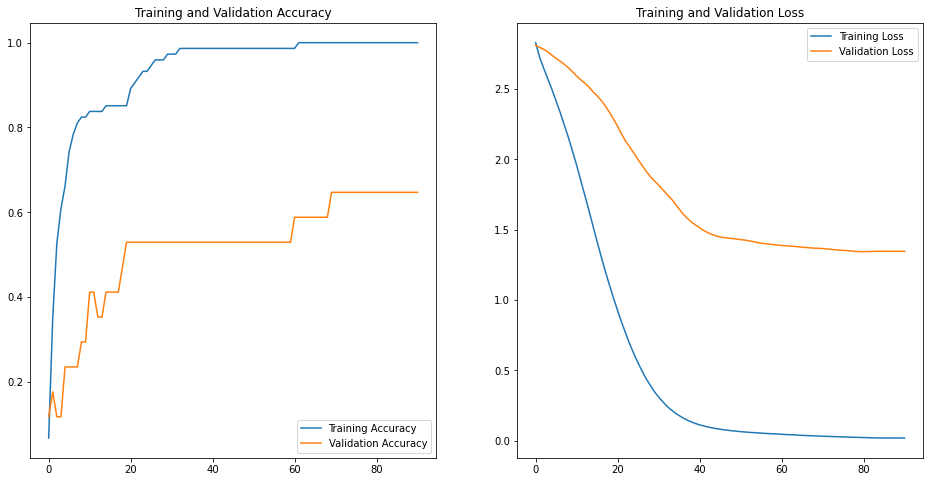

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
[np.argmax(i) for i in model.predict(X_test)][:10]

[0, 1, 2, 11, 4, 9, 6, 1, 9, 10]

In [50]:
[np.argmax(i) for i in y_test][:10]

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10]

## New user question encoding

In [51]:
def get_text():
    input_text  = ['what are you']
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input 

In [52]:
#load artifacts 
from tensorflow.keras.models import load_model
model = load_model('model-v1.h5')
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

In [53]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [54]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [55]:
# df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
# df_input

In [56]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=16, padding='post')
    return padded

In [57]:
# encoded_input = encode_input_text(tokenizer_t,df_input,'questions')
# encoded_input.shape

In [58]:
# encoded_input

In [59]:
def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred

In [60]:
# mapper

In [61]:
# df2.head()

In [62]:
def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred

In [63]:
def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]
    

In [64]:
def bot_response(response,):
    print(response)

In [65]:
df_input = get_text()

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

Call me ChatBot
